<a href="https://colab.research.google.com/github/MadelayneLoor/ABSA_TESIS_MODELS/blob/main/Modelo_1_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABSA basado en textos de retroalimentacione educativas

## Importacion de los paquetes necesarios

In [1]:
#pip install numpy
#pip install pandas
#pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# Clonar el repositorio y cargar el dataset
!git clone https://github.com/MadelayneLoor/ABSA_Tesis.git
dataset_path = "./ABSA_Tesis/datasetABSA.csv"

# Verificar si el dataset existe antes de continuar
if os.path.exists(dataset_path):
    # Leer el dataset
    data = pd.read_csv(dataset_path)
    # Extraer columnas necesarias
    sentences = data['Comentario'].tolist()  # Columna 'Comentario'
    aspects = data['Aspecto'].tolist()       # Columna 'Aspecto'
    polarities = data['Polaridad'].tolist()  # Columna 'Polaridad'
    # Revisar las primeras filas
    print("Primeras filas del dataset:")
    print(data.head())
else:
    raise FileNotFoundError(f"El archivo {dataset_path} no fue encontrado. Por favor, verifica la ruta o si el repositorio contiene el archivo.")

Cloning into 'ABSA_Tesis'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 523.02 KiB | 4.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Primeras filas del dataset:
                                          Comentario     Aspecto  Polaridad
0               la caratula sin errores ortograficos    caratula          2
1  la estructura del documento se visualiza corre...  estructura          1
2  no existen herencias la relacion entre los cas...   herencias          0
3  al existir tantos errores en el procedimientos...     errores          0
4               la caratula sin errores ortograficos    caratula          2


In [4]:
data.shape

(4253, 3)

In [5]:
summary = data.describe(include='all')
summary

,Comentario,Aspecto,Polaridad
count,4253,4253,4253.000000
unique,3564,218,NaN
top,el flujo base y flujo alterno de las actividad...,nombre,NaN
freq,23,283,NaN
mean,NaN,NaN,0.962850
std,NaN,NaN,0.853598
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


In [6]:
longest_sentence_length = data['Comentario'].apply(len).max()
longest_sentence_length

765

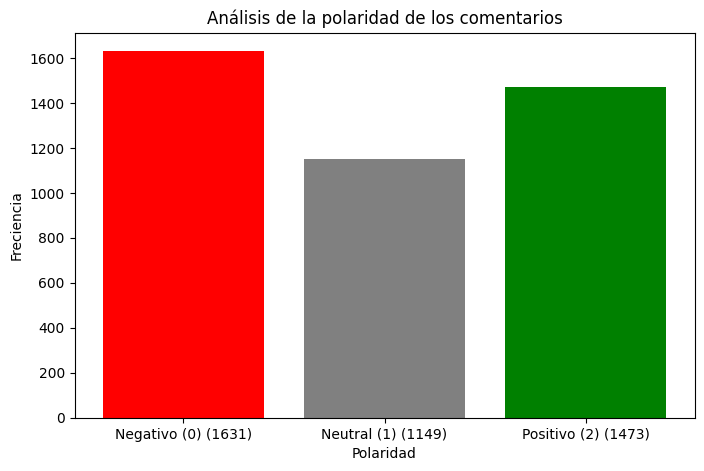

In [7]:
labels = ['Negativo (0)', 'Neutral (1)', 'Positivo (2)']
polarity_counts = data['Polaridad'].value_counts().sort_index()
polarity_counts_sorted = polarity_counts.sort_index()
adjusted_labels = [f'{label} ({count})' for label, count in zip(labels[:len(polarity_counts_sorted)], polarity_counts_sorted)]

plt.figure(figsize=(8, 5))
plt.bar(adjusted_labels, polarity_counts_sorted, color=['red', 'gray', 'green'] [:len(polarity_counts_sorted)])

plt.title('Análisis de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('Freciencia')
plt.show()


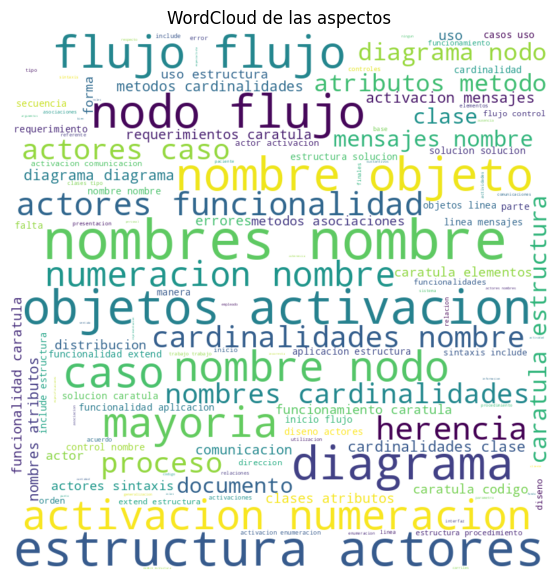

In [8]:
aspectt_text = " ".join(data['Aspecto'])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(aspectt_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las aspectos")
plt.show()


## Porcesamiento de data

In [9]:
data['Comentario'] = data.apply(lambda row: f"[CLS] {row['Comentario']} [SEP] {row['Aspecto']} [SEP]", axis=1)

In [10]:
data.head()

,Comentario,Aspecto,Polaridad
0,[CLS] la caratula sin errores ortograficos [SE...,caratula,2
1,[CLS] la estructura del documento se visualiza...,estructura,1
2,[CLS] no existen herencias la relacion entre l...,herencias,0
3,[CLS] al existir tantos errores en el procedim...,errores,0
4,[CLS] la caratula sin errores ortograficos [SE...,caratula,2


In [11]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    #stratify=data['Polaridad']
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['Polaridad']
)

print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Train samples: {len(train_data)}")


Validation samples: 638
Test samples: 638
Train samples: 2977


## Entrenamiendo del modelo

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence = row["Comentario"]
        label = row["Polaridad"]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [14]:
# Tokenizador dataset

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 256

train_dataset = SentimentDataset(train_data, tokenizer, max_len)
val_dataset = SentimentDataset(val_data, tokenizer, max_len)
test_dataset = SentimentDataset(test_data, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
from transformers import BertForSequenceClassification, get_scheduler

#Modelo

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',  num_labels=3)

model.to(device)

#optimizar an scheduler

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.005)
num_training_steps = len(train_dataloader) * 3  # 3 epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [20]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=f998a10bb42f9c35417e6fad4cb84cdf944456b858c148ff025ca842e7238778
  Stored in directory: /root/.cache/pip/wheels/47/50/9e/29dc79037d74c3c1bb4a8661fb608e8674b7e4260d6a3f8f51
Successfully built nvidia-ml-py3


## Entrenamiendo del modelocon 5 epocas

In [21]:
import time
import torch
import psutil
import matplotlib.pyplot as plt
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetUtilizationRates

# Inicializar NVML para obtener métricas de GPU
nvmlInit()
gpu_handle = nvmlDeviceGetHandleByIndex(0)

# Listas para almacenar métricas
train_losses = []
val_losses = []
cpu_usages = []
ram_usages = []
gpu_usages = []
gpu_memories = []

epochs = 5
start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Capturar métricas antes de la época
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().used / (1024 ** 3)  # RAM en GB

    train_loss = train_one_epoch(model, train_dataloader, optimizer, device, lr_scheduler)
    val_loss = evaluate(model, val_dataloader, device)

    # Capturar métricas después de la época
    cpu_end = psutil.cpu_percent(interval=None)
    ram_end = psutil.virtual_memory().used / (1024 ** 3)

    # Calcular valores absolutos
    cpu_usage = (cpu_start + cpu_end) / 2
    ram_used = ram_end  # Ahora guardamos el valor absoluto
    gpu_info = nvmlDeviceGetMemoryInfo(gpu_handle)
    gpu_utilization = nvmlDeviceGetUtilizationRates(gpu_handle)

    gpu_memory = gpu_info.used / (1024 ** 3)
    gpu_usage = gpu_utilization.gpu

    # Almacenar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    cpu_usages.append(cpu_usage)
    ram_usages.append(ram_used)
    gpu_usages.append(gpu_usage)
    gpu_memories.append(gpu_memory)

    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Métricas finales
end_time = time.time()
total_time = end_time - start_time
avg_cpu = sum(cpu_usages) / len(cpu_usages)
avg_ram = sum(ram_usages) / len(ram_usages)
avg_gpu = sum(gpu_usages) / len(gpu_usages)
avg_gpu_memory = sum(gpu_memories) / len(gpu_memories)

print("\n--- Estadísticas Finales del Entrenamiento ---")
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos ({total_time / 60:.2f} minutos)")
print(f"Uso promedio de CPU: {avg_cpu:.2f}%")
print(f"Memoria RAM promedio utilizada: {avg_ram:.2f} GB")
print(f"Uso promedio de GPU: {avg_gpu:.2f}%")
print(f"Memoria GPU promedio utilizada: {avg_gpu_memory:.2f} GB")


Epoch 1/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.72it/s]


Training Loss: 0.8092, Validation Loss: 0.4343
Epoch 2/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Training Loss: 0.3549, Validation Loss: 0.2979
Epoch 3/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.68it/s]


Training Loss: 0.1988, Validation Loss: 0.2515
Epoch 4/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.72it/s]


Training Loss: 0.1566, Validation Loss: 0.2515
Epoch 5/5


Evaluation: 100%|██████████| 80/80 [00:09<00:00,  8.68it/s]

Training Loss: 0.1517, Validation Loss: 0.2515

--- Estadísticas Finales del Entrenamiento ---
Tiempo total de entrenamiento: 644.64 segundos (10.74 minutos)
Uso promedio de CPU: 49.38%
Memoria RAM promedio utilizada: 2.31 GB
Uso promedio de GPU: 90.80%
Memoria GPU promedio utilizada: 4.71 GB


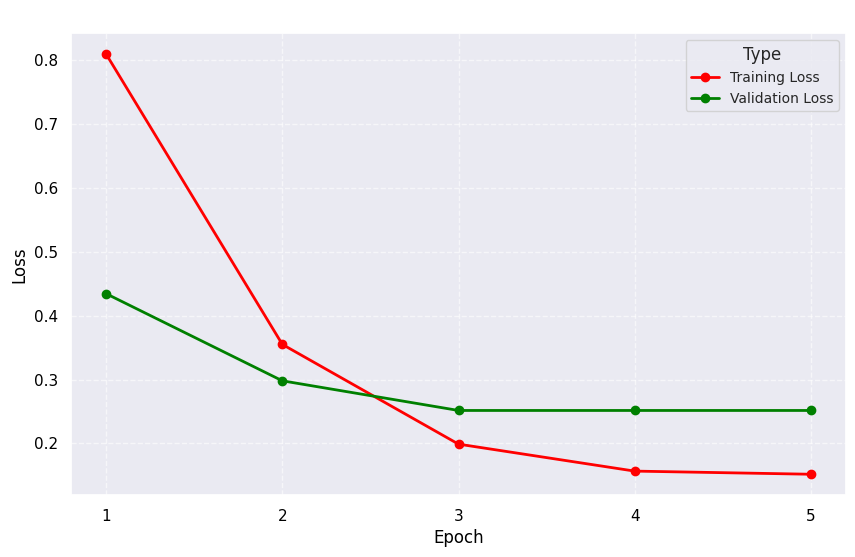

In [22]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Loss per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Loss', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='upper right')

# Cambiar fondo de la gráfica a oscuro
plt.show()

## Guardar el modelo

In [23]:
save_directory = "ABSA_model_v1"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modelo Tokenizado '{save_directory}' guardado!!!")

Modelo Tokenizado 'ABSA_model_v1' guardado!!!


## Porceso de prueba

In [24]:
from sklearn.metrics import classification_report
def test_model(model, data_loader, device, class_names):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():

        for batch in data_loader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    precision = precision_score(true_labels, predictions, average="weighted", zero_division=0)

    # Generar informe detallado por clase
    report = classification_report(true_labels, predictions, target_names=class_names, zero_division=0)

    return accuracy, precision, f1, report

# Lista de nombres de las clases en el mismo orden que las etiquetas
class_names = ["Negativo", "Neutral", "Positivo"]

test_accuracy, test_precision, test_f1 , test_report = test_model(model, test_dataloader, device, class_names)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test F1 Score: {test_f1:.4f}")
print("\nDetailed Classification Report:")
print(test_report)


Test Accuracy: 0.9263, Test Precision: 0.9262, Test F1 Score: 0.9261

Detailed Classification Report:
              precision    recall  f1-score   support

    Negativo       0.92      0.94      0.93       239
     Neutral       0.92      0.88      0.90       178
    Positivo       0.94      0.95      0.94       221

    accuracy                           0.93       638
   macro avg       0.93      0.92      0.92       638
weighted avg       0.93      0.93      0.93       638



## Pueba del modelo

In [25]:
def predict_aspect_sentiment(model, tokenizer, text, aspect, device, max_len=256):


    formatted_text = f"[CLS] {text} [SEP] {aspect} [SEP]"

    encoding = tokenizer(
        formatted_text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    label_mapping_reverse = {0: "Negativo", 1: "Neutral", 2: "Positivo"}
    sentiment = label_mapping_reverse[predicted_class]

    return sentiment


In [26]:
!python -m spacy download es_core_news_sm
import spacy
nlp = spacy.load("es_core_news_sm")

# Función para extraer el primer aspecto de un comentario
def extract_aspect(comment):
    doc = nlp(comment)
    for token in doc:
        # Buscar el primer sustantivo
        if token.pos_ in ("NOUN"):
            return token.text
    return None  # Si no se encuentra ningún sustantivo, devolver None



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:
text = "Los sistemas empresariales están descritos de manera parcialmente correcta, le falta detallar el tipo de gestión."
# Extraer el aspecto del texto
aspect = extract_aspect(text)

predicted_sentiment = predict_aspect_sentiment(
    model, tokenizer, text, aspect, device
)

print(f"Comentario: {text}")
print(f"Aspecto: {aspect}")
print(f"Sentimiento Predicho: {predicted_sentiment}")

Comentario: Los sistemas empresariales están descritos de manera parcialmente correcta, le falta detallar el tipo de gestión.
Aspecto: sistemas
Sentimiento Predicho: Neutral
